# data, preprocessing, encoding

> 여러 종류의 data를 read하는 방법, 데이터를 전처리하는 방법 등 데이터 분석에서 기본이 되는 기술들에 대해 배워보는 시간이었으면 좋겠습니다. 더 나아가 대회에 적용해보시면 좋을 거 같습니다.

## 환경 설정 [😉 이 코드는 반드시 실행하세요! 😉]
> 만약 구글 드라이브 마운트(Google Drive Mount)가 안되어있다면 꼭 마운트를 하고나서 진행한다!
- 패키지 설치 및 임포트
- **실습을 위한 폴더 경로 설정** <- 😄 반드시 이 파일이 위치한 경로로 수정하세요!!! 😄
- 실습 자료 iris 데이터넷 다운로드

환경 설정 이후 ML파이프라인의 원하는 단계로 가서 코드를 실행한다. 각 단계에서 데이터셋과 관련된 코드가 맨 처음 위치하고 있다면 꼭 실행해주자.



### A. 패키지 설치 및 임포트

In [4]:
!pip install -q -U PyYAML
!pip install -q -U scikit-learn
!pip install -q shap eli5 cairosvg jupyter_contrib_nbextensions pip install category_encoders
!pip install cairosvg

In [5]:
import os
import gc
import time
import itertools
import random

from collections import OrderedDict, defaultdict
from abc import *

# 설정
from datetime import datetime

import yaml
import glob
import shutil

# Log
import logging

# I/O
from cairosvg import svg2png
from PIL import Image
from io import BytesIO
from tqdm import tqdm

# 공학용 연산
import numpy as np
import pandas as pd

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import missingno

import pprint
pp = pprint.PrettyPrinter(indent=1)

# 머신러닝
import lightgbm as lgb

# 딥러닝
import torch
from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.nn.functional as F

OSError: no library called "cairo-2" was found
no library called "cairo" was found
no library called "libcairo-2" was found
cannot load library 'libcairo.so.2': libcairo.so.2: cannot open shared object file: No such file or directory.  Additionally, ctypes.util.find_library() did not manage to locate a library called 'libcairo.so.2'
cannot load library 'libcairo.2.dylib': libcairo.2.dylib: cannot open shared object file: No such file or directory.  Additionally, ctypes.util.find_library() did not manage to locate a library called 'libcairo.2.dylib'
cannot load library 'libcairo-2.dll': libcairo-2.dll: cannot open shared object file: No such file or directory.  Additionally, ctypes.util.find_library() did not manage to locate a library called 'libcairo-2.dll'

In [ ]:
import warnings

# warning을 보고 싶지 않을 경우 아래 코드 활성화
# warnings.filterwarnings('ignore')

### B. 실습을 위한 폴더 경로 설정 <- 😄 반드시 이 파일이 위치한 경로로 수정하세요!!! 😄

In [ ]:
# 이 실습 파일이 위치하고 있는 경로!
# 😄 반드시 이 파일이 위치한 경로로 수정하세요!!! 😄
PROJECT_PATH = "/data/ephemeral/home/level2-dkt-recsys-06/code/"

In [ ]:
# 실습을 위한 data 폴더 생성
DATA_PATH = os.path.join(PROJECT_PATH, 'data')
if not os.path.isdir(DATA_PATH):
    os.mkdir(DATA_PATH)

### C. 실습 자료 iris 데이터넷 다운로드

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()

# iris pandas DataFrame 제작!
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df["class"] = pd.Categorical.from_codes(iris.target, ['Iris-' + name for name in list(iris.target_names)])

# 뒤에 저장된 csv를 활용하는 코드들과의 호환성을 위해 저장!
iris_df.to_csv(os.path.join(DATA_PATH, 'iris.csv'), index=False)

iris_df.sample(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
69,5.6,2.5,3.9,1.1,Iris-versicolor
1,4.9,3.0,1.4,0.2,Iris-setosa
139,6.9,3.1,5.4,2.1,Iris-virginica
58,6.6,2.9,4.6,1.3,Iris-versicolor
117,7.7,3.8,6.7,2.2,Iris-virginica


## 📚 데이터 (Data)

- 데이터셋 다운로드 (Download Dataset)
- 데이터셋 제작 (Make Dataset)
- 데이터 압축 (Compress Data)
- 데이터 저장 (Save Data)
- 데이터 읽기 (Read Data)
- 데이터 나누기 (Split Data)



### 📗 데이터셋 다운로드 (Download Dataset)

> 머신러닝 프로젝트에는 데이터셋은 필수이다. 이미 만들어진 데이터셋이 있을 경우 이를 다운로드 하는 방법에 대해 살펴보자

1. 홈페이지에서 직접 데이터셋 검색 후 다운로드 받기
2. 프로그램을 이용해 데이터셋 다운로드 받기
3. ML 라이브러리 데이터셋 패키지 활용

#### 1. 홈페이지에서 직접 데이터셋 검색 후 다운로드 받기

> 가장 간단한 방법으로 데이터가 업로드되어 있는 사이트로 가서 원하는 데이터셋을 찾아낸 이후 데이터셋을 GUI(그래픽 인터페이스)를 이용하여 다운로드 받는다

- [Google Dataset Search](https://datasetsearch.research.google.com/)
- [UCI Machine Learing Repository](http://archive.ics.uci.edu/ml/index.php)
- [Kaggle Datasets](https://www.kaggle.com/datasets)
- [CMU Machine Learning and AI: Find Datasets](https://guides.library.cmu.edu/machine-learning/datasets)
- [AWS open dataset](https://registry.opendata.aws/)

#### 2. 프로그램을 이용해 데이터셋 다운로드 받기
- python `requests` 라이브러리 활용

##### python `requests` 라이브러리 활용

> 데이터셋의 url을 알고 있을 경우 코드를 이용해 데이터셋을 다운로드 받을 수 있다

- [Request Quickstart](https://requests.readthedocs.io/en/master/user/quickstart/)

In [ ]:
import requests

iris_data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
iris_name_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.names'

def download_url(url, path):
    response = requests.get(url)
    if response.status_code == 200:
        with open(path, 'wb') as f:
            f.write(response.content)

# iris 데이터셋 다운로드 후 저장
iris_data_path = os.path.join(DATA_PATH, 'iris.data')
iris_name_path = os.path.join(DATA_PATH, 'iris.names')

download_url(iris_data_url, iris_data_path)
download_url(iris_name_url, iris_name_path)

# iris names 정보에서 column명 파악하기
with open(iris_name_path, 'rb') as f:
    iris_name = f.read().decode('utf8')

print('\n'.join(iris_name.split('\n')[49:58]))

# iris data column명 추가하여 읽어오기
iris_df = pd.read_csv(iris_data_path,
                      header=None,
                      names=['sepal length (cm)',
                              'sepal width (cm)',
                              'petal length (cm)',
                              'petal width (cm)',
                              'class'])
iris_df.sample(5)

7. Attribute Information:
   1. sepal length in cm
   2. sepal width in cm
   3. petal length in cm
   4. petal width in cm
   5. class: 
      -- Iris Setosa
      -- Iris Versicolour
      -- Iris Virginica


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
12,4.8,3.0,1.4,0.1,Iris-setosa
36,5.5,3.5,1.3,0.2,Iris-setosa
56,6.3,3.3,4.7,1.6,Iris-versicolor
28,5.2,3.4,1.4,0.2,Iris-setosa
76,6.8,2.8,4.8,1.4,Iris-versicolor


#### 3. ML 라이브러리 데이터셋 패키지 활용

> 데이터셋을 쉽게 다운로드 받을 수 있는 서브 패키지

- ##### [sklearn.datasets](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets)

##### sklearn.datasets
> 위에서 `requests`를 이용하여서 다운로드하였던 iris 데이터셋을 쉽게 다운로드 할 수 있다

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()

df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df["class"] = pd.Categorical.from_codes(iris.target, ['Iris-' + name for name in list(iris.target_names)])

df.sample(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
106,4.9,2.5,4.5,1.7,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
67,5.8,2.7,4.1,1.0,Iris-versicolor
147,6.5,3.0,5.2,2.0,Iris-virginica
7,5.0,3.4,1.5,0.2,Iris-setosa


### 📗 데이터셋 제작 (Make Dataset)

> 만약 필요한 데이터셋이 없다면 직접 제작하여야 한다.

1. 웹페이지 크롤링 (Webpage Crawling)
2. API (Application Programming Interface)
3. 데이터셋 합치기 (Merging Dataset)
4. 라벨링 (Labeling)

#### 1. 웹페이지 크롤링 (Webpage Crawling)
- [selenium 공식문서](https://selenium-python.readthedocs.io/)
- [BeautifulSoup 공식문서](https://beautiful-soup-4.readthedocs.io/en/latest/)

##### selenium

> 매우 강력하고 유명한 크롤러로 자바스크립트로 동작하는 동적 웹페이지에서 손쉽게 정보를 크롤링 할 수 있다. 구글에 활용 방법에 대한 매우 많은 정보가 있다.

![selenium](https://selenium-python.readthedocs.io/_static/logo.png)

##### BeautifulSoup

> HTML과 XML형식의 웹페이지에서 정보를 크롤링하는 파이썬 라이브러리다. 가장 기초적이며 가볍지만 자바스크립트 기반 동적 웹페이지에서의 크롤링은 Selenium 사용을 적극 권장한다

![BeautifulSoup](https://beautiful-soup-4.readthedocs.io/en/latest/_images/6.1.jpg)



#### 2. API (Application Programming Interface)

> 많은 웹페이지들이 자신들의 정보를 제공하는 API를 지원한다. 이를 활용한다면 크롤링 없이 정보를 손쉽게 얻을 수 있다.

API 예시
- [youtube API](https://developers.google.com/youtube/)
- [facebook API](https://developers.facebook.com/)
- [wikipedia API](https://www.mediawiki.org/wiki/API:Main_page)

#### 3. 데이터셋 합치기 (Merging Dataset)

> 제작하고자 하는 데이터셋의 정보가 인터넷 상에는 존재하지만 여기저기 흩어져있는 경우 이 데이터셋들을 모아서 하나의 데이터셋을 구축할 수도 있다. 일부 정보가 누락된 경우 위의 2가지 방법을 통해 해당 누락된 정보를 모아서 나머지 데이터셋들과 합쳐 필요한 데이터셋을 만들 수도 있다.


#### 4. 라벨링 (Labeling)

> 데이터셋의 정보들을 모두 모은 상태에서 추가적으로 라벨을 붙여야 할 수도 있다. 이 경우 라벨링 툴을 개발하거나 이용해 직접 한땀한땀 붙여도 상관없지만 관련된 업무를 수행해주는 회사를 이용하는 방법도 있다.

- 데이타 라벨링 툴 제작
- 데이터 라벨링 툴 이용
- 데이터 라벨링 전문 회사에 의뢰

##### 데이터 라벨링 전문 회사에 의뢰

- [Appen](https://appen.com/)
- [Amazon Mechanical Turk](https://www.mturk.com/)
- [Scale AI](https://scale.com/)

### 📗 데이터 압축 (Compress Data)

> 데이터의 크기가 너무 클 경우 크기를 줄일 필요가 있다. 데이터의 종류에 따라 적절한 데이터 압축 방식을 택해야 한다.

1. 정형 데이터 (Structured data)
2. 비정형 데이터 (Unstructured data)

#### 1. 정형 데이터 (Structured data)
- pandas DataFrame 압축

##### pandas DataFrame 압축

> 정형 데이터를 다룰 때 흔히 pandas DataFrame이 사용된다. 자료의 정보 손실을 최소화하면서 각 열의 자료구조를 바꿈으로서 데이터의 크기를 압축한다.

< 출처 - https://www.kaggle.com/alexeykupershtokh/safe-memory-reduction >

In [ ]:
def compress_series(col, deep=True, verbose=False, obj_to_cat=False):
    """Downcast the datatype of pandas Series

    Reference - https://www.kaggle.com/alexeykupershtokh/safe-memory-reduction
    """

    numerics = ['int16',
                'uint16',
                'int32',
                'uint32',
                'int64',
                'uint64',
                'float16',
                'float32',
                'float64']

    start_mem = col.memory_usage(deep=deep) / 1024 ** 2

    col_type = col.dtypes

    # numerics
    if col_type in numerics:
        col = _compress_numeric_column(col)

    # strings
    if (col_type == 'object') and obj_to_cat:
        col = col.astype('category')

    if verbose:
        print(f'Column : {col_type} -> {col.dtypes}')

    end_mem = col.memory_usage(deep=deep) / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    if verbose:
        if start_mem == end_mem:
            print('Failed to compress column')
        else:
            print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return col

def compress_df(df, deep=True, verbose=False, obj_to_cat=False):

    """Downcast the datatype of pandas DataFrame

    Reference - https://www.kaggle.com/alexeykupershtokh/safe-memory-reduction
    """
    numerics = ['int16',
                'uint16',
                'int32',
                'uint32',
                'int64',
                'uint64',
                'float16',
                'float32',
                'float64']

    start_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes

        # numerics
        if col_type in numerics:
            df[col] = _compress_numeric_column(df[col])

        # strings
        if (col_type == 'object') and obj_to_cat:
            df[col] = df[col].astype('category')

        if verbose:
            print(f'Column {col}: {col_type} -> {df[col].dtypes}')

    end_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    if verbose:
        print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return df

def _compress_numeric_column(col,
                             max_loss_limit=0.001,
                             avg_loss_limit=0.001,
                             na_loss_limit=0,
                             n_uniq_loss_limit=0,
                             fillna=0):
    """Downcast the datatype of pandas Series with numeric datatype

    Reference - https://www.kaggle.com/alexeykupershtokh/safe-memory-reduction

    Args:
        col (pd.Series): Target column to downcast
        max_loss_limit: don't allow any float to lose precision
                        more than this value. Any values are ok for
                        GBT algorithms as long as you don't unique values.
                        See https://en.wikipedia.org/wiki/Half-precision_floating-point_format#Precision_limitations_on_decimal_values_in_[0,_1]
        avg_loss_limit: same but calculates average throughout the series.
        na_loss_limit: not really useful.
        n_uniq_loss_limit: very important parameter.
                            If you have a float field with very high cardinality
                            you can set this value to something like
                            n_records * 0.01 in order to allow some field relaxing.

    Returns:
        pd.Series: Output column that is finished downcasting or failed downcasting

    """
    is_float = str(col.dtypes)[:5] == 'float'
    na_count = col.isna().sum()
    n_uniq = col.nunique(dropna=False)

    try_types = ['float16', 'float32']
    if na_count <= na_loss_limit:
        try_types = ['int8', 'int16', 'float16', 'int32', 'float32']

    # try downcast to type which the size is smallest to largest
    for try_type in try_types:
        col_tmp = col

        # float to int conversion
        # try to round to minimize casting error
        if is_float and (str(try_type)[:3] == 'int'):
            col_tmp = col_tmp.copy().fillna(fillna).round()

        # downcast
        col_tmp = col_tmp.astype(try_type)

        max_loss = (col_tmp - col).abs().max()
        avg_loss = (col_tmp - col).abs().mean()
        na_loss = np.abs(na_count - col_tmp.isna().sum())
        n_uniq_loss = np.abs(n_uniq - col_tmp.nunique(dropna=False))

        # If every condition matches than return that column
        if (max_loss <= max_loss_limit and
            avg_loss <= avg_loss_limit and
            na_loss <= na_loss_limit and
            n_uniq_loss <= n_uniq_loss_limit):
            return col_tmp

    # failed to downcast the column
    return col

In [ ]:
# pandas Series 압축
original_series = pd.Series([1, 2, 3])
compressed_series = compress_series(original_series, verbose=True)

Column : int64 -> int8
Mem. usage decreased from  0.00 Mb to  0.00 Mb (13.8% reduction)


In [ ]:
# pandas DataFrame 압축
original_df = pd.DataFrame({'a': [1, 2, 3], 'b': [4, 5, 6], 'c': ['duck', 'said', 'quark']})
compressed_df = compress_df(original_df, verbose=True)

Column a: int64 -> int8
Column b: int64 -> int8
Column c: object -> object
Mem. usage decreased from  0.00 Mb to  0.00 Mb (11.7% reduction)


#### 2. 비정형 데이터 (Unstructured data)
- 이미지 압축

### 📗 데이터 저장 (Save Data)

> 기존 데이터셋을 변형하거나 새로운 데이터셋을 만들었다면 이를 저장해두어야 한다. 다양한 파일 포맷이 있으며 데이터의 크기와 종류, 컴퓨터의 성능, 사용 맥락에 따라 적절한 데이터 포맷을 선정하여야 한다.

1. 정형 데이터 (Structured data)
2. 비정형 데이터 (Unstructured data)
3. 반정형 데이터 (Semi-structured data)

**유용한 자료**
- [Kaggle에서 사용되는 데이터 포맷 종류](https://www.kaggle.com/docs/datasets#types-of-datasets)
- [The Best Format to Save Pandas Data](https://towardsdatascience.com/the-best-format-to-save-pandas-data-414dca023e0d)




#### 1. 정형 데이터 (Structured data)

> 정해진 데이터 저장 규격이 있는 데이터들이다. 테이블 형태로 표현 가능하고 관계형 데이터베이스에 저장될 수 있는 데이터들을 지칭한다. 데이터의 크기가 작을 때에는 csv, excel과 같은 포맷을 선택할 수도 있지만, 데이터 크기가 매우 커지기 시작하면 관계형 데이터베이스을 사용해야 할 수도 있다.

**사용할 수 있는 저장 포맷 종류**

- csv
- excel
- [pickle](https://docs.python.org/ko/3/library/pickle.html)
- feather
- hdf5
- sqlite3
- BigQuery

In [ ]:
# 저장에 사용할 iris dataset 읽어오기
csv_path = os.path.join(DATA_PATH, 'iris.csv')
iris_df = pd.read_csv(csv_path)

##### csv

> 매우 대중적인 comma(,)로 구분된 텍스트 파일이다. 데이터 저장 크기가 작고 직접 파일을 열어서 값을 확인하기도 편하다. **Kaggle에서 가장 많이 사용되는 포맷이다.**

In [ ]:
# csv로 저장하기
iris_csv_path = os.path.join(DATA_PATH, 'iris.csv')
iris_df.to_csv(iris_csv_path, index=False)

##### pickle

> 파이썬 객체를 직렬화하여 바이너리로 저장한다.



In [ ]:
iris_pickle_path = os.path.join(DATA_PATH, 'iris.pkl')
iris_df.to_pickle(iris_pickle_path)

##### feather

> 이름처럼 빠르고, 가벼우며, 사용하기 쉬운 데이터를 저장하기 위한 바이너리 파일 포맷이다


In [ ]:
iris_feather_path = os.path.join(DATA_PATH, 'iris.ftr')
iris_df.to_feather(iris_feather_path)

##### sqlite3

> 정형 데이터로 이루어진 데이터셋에 테이블 종류가 많거나 데이터 크기가 매우 큰 상황(10억개의 행)에서 지속적으로 데이터를 읽어와야 할 경우 관계형 데이터베이스를 사용하는 것이 권장된다.

- sqlalchemy

In [ ]:
from sqlalchemy import create_engine

# 데이터베이스 연결
engine = create_engine(f'sqlite:///{DATA_PATH}/iris.db')

# sqlite db로 저장
iris_df.to_sql('master', engine, index=False)

#### 2. 비정형 데이터 (Unstructured data)
> 텍스트, 음성, 이미지, 영상과 같은 자료가 여기에 속한다. 따로 정해진 데이터 규격이 없으며 정보 하나당 파일 하나를 차지하는 경우가 많다. 이미지나 영상처럼 크기가 큰 비정형 데이터의 경우, 파일 자체가 아니라 파일 주소를 데이터베이스에 저장하여 관리하기도 한다.

**사용할 수 있는 저장 포맷 종류**
- 텍스트 (txt)
- 이미지 (jpg, png)
- 영상 (mp4)
- 음성 (wav)
- 이메일
- pdf
- MongoDB

#### 3. 반정형 데이터 (Semi-structured data)
> 정해진 데이터 규격이 존재하지만 기존 관계형 데이터베이스나 테이블 형태로 저장할 수 없는 데이터들이다.

**사용할 수 있는 저장 포맷 종류**

- html
- xml
- json
- protobuf
- MongoDB
- DynamoDB

### 📗 데이터 읽기 (Read Data)

> 데이터가 어떤 포맷으로 저장되어있는지를 확인하고 포맷에 맞춰 데이터를 읽어오면 된다. 다만 사용하고 있는 컴퓨터의 성능에 따라 한번에 읽어올 수 있는 데이터의 크기가 제한된다. 만약 데이터의 크기가 한번에 읽어오기 힘든 크기라면 나눠서 읽는 방법이 있다.

1. 정형 데이터 (Structured data)
2. 비정형 데이터 (Unstructured data)
3. 반정형 데이터 (Semi-structured data)

#### 1. 정형 데이터 (Structured data)

- csv
- excel
- pickle
- feather
- hdf5
- sqlite3
- BigQuery

##### csv
- 한번에 읽어오기
- 나눠서 읽기
- 데이터 타입 지정해서 읽기

- **한번에 읽어오기**

In [ ]:
# read_csv로 파일을 읽어오면 된다
csv_path = os.path.join(DATA_PATH, 'iris.csv')
pd.read_csv(csv_path).sample(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
106,4.9,2.5,4.5,1.7,Iris-virginica
56,6.3,3.3,4.7,1.6,Iris-versicolor
15,5.7,4.4,1.5,0.4,Iris-setosa
104,6.5,3.0,5.8,2.2,Iris-virginica
136,6.3,3.4,5.6,2.4,Iris-virginica


- **나눠서 읽기**
    1. pandas read_csv를 이용해 csv 파일을 chunk단위로 나눠서 읽기
    2. 읽어온 모든 chunk단위 DataFrame들을 concat

    - **[ 왜 필요한가? ]**
        - `train.csv` 크기 **5.7GB**
        - Colab ram 크기 **12GB**
        > 만약 우리가 `train.csv`를 한 번에 읽어오면 csv를 읽어오는 과정에 사용하는 ram의 크기가 12GB보다 커지게 되어 colab은 세션을 다시 시작하게 된다.

In [ ]:
# chunk단위로 csv를 읽는 csv reader를 생성한다
csv_reader = pd.read_csv(csv_path, chunksize=100)

# csv를 chunk단위로 읽어 리스트에 보관한다
csv_chunk_list = []
for csv_chunk in csv_reader:
    csv_chunk_list.append(csv_chunk)

# 읽어온 모든 csv chunk들을 concat하여 하나의 DataFrame을 생성한다
pd.concat(csv_chunk_list).sample(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
95,5.7,3.0,4.2,1.2,Iris-versicolor
131,7.9,3.8,6.4,2.0,Iris-virginica
26,5.0,3.4,1.6,0.4,Iris-setosa
59,5.2,2.7,3.9,1.4,Iris-versicolor
25,5.0,3.0,1.6,0.2,Iris-setosa


- 데이터 타입 지정해서 읽기
> 직접 데이터 타입을 지정하기 때문에 추가로 전처리할 필요가 없이 바로 원하는 형태의 데이터를 사용할 수 있으며 크기가 큰 파일을 읽을 때 유용하다. 예로 데이터 타입 지정 없이 읽을 경우 `int64`로 지정되는데 이를 `int8` 데이터 타입으로 읽을 경우 메모리를 8배 적게 사용한다.

In [ ]:
# read_csv로 파일을 읽어오면 된다
csv_path = os.path.join(DATA_PATH, 'iris.csv')
iris_df = pd.read_csv(csv_path,
                      dtype={'sepal length (cm)': 'float32',
                             'sepal width (cm)': 'float32',
                             'petal length (cm)': 'float64',
                             'petal width (cm)': 'float64',
                             'class': 'category'})

In [ ]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   sepal length (cm)  150 non-null    float32 
 1   sepal width (cm)   150 non-null    float32 
 2   petal length (cm)  150 non-null    float64 
 3   petal width (cm)   150 non-null    float64 
 4   class              150 non-null    category
dtypes: category(1), float32(2), float64(2)
memory usage: 3.8 KB


##### sqlite

- sqlalchemy

In [ ]:
from sqlalchemy import create_engine, text

# 데이터베이스 연결
engine = create_engine(f'sqlite:///{DATA_PATH}/iris.db')

# sqlite db에서 정보 읽어오기
iris_df = pd.read_sql_query(sql=text("SELECT * FROM master"), con=engine.connect())
iris_df.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


#### 2. 비정형 데이터 (Unstructured data)
- 텍스트 (txt)
- 이미지 (jpg, png)
- 영상 (mp4)
- 음성 (wav)
- 이메일
- pdf

#### 3. 반정형 데이터 (Semi-structured data)

- html
- xml
- json
- protobuf
- MongoDB
- DynamoDB

### 📗 데이터 나누기 (Split Data)

> 데이터가 준비되었으면 우리는 이를 바탕으로 Train, Validation, Test 셋으로 데이터를 나눠야 한다

1. sklearn 라이브러리 사용하기
2. Custom 함수 제작하기

#### 1. sklearn 라이브러리 사용하기

> 데이터를 나누는 것은 머신러닝에 필수적인만큼 sklearn에는 이를 위한 다양한 함수 및 클래스들이 있으며 대표적인 몇 가지만 소개한다.

- [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split)
- [sklearn.model_selection.KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold)
- [sklearn.model_selection.StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold)
- [sklearn.model_selection.TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html#sklearn.model_selection.TimeSeriesSplit)

**참고자료**
- [model selection - sklearn 공식문서](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)
- [Cross-validation: evaluating estimator performance - sklearn 공식문서](https://scikit-learn.org/stable/modules/cross_validation.html)

##### train_test_split
> 가장 흔히 사용되는 함수다. 데이터셋을 정해진 비율만큼 나눠주며 Train, Validation, Test 3가지 데이터셋을 만들기 위해서는 2번에 걸쳐서 나눠야 한다. `stratify` 옵션이 존재하며 이를 통해 클래스별로 데이터셋을 나눌 수가 있다

```python
train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)
```


In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split

from sklearn.model_selection import train_test_split
from sklearn import datasets

X, y = datasets.load_iris(return_X_y=True)
X.shape, y.shape

((150, 4), (150,))

In [ ]:
# Train, Test셋으로 분리!
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((120, 4), (120,), (30, 4), (30,))

In [ ]:
# Train, Validation셋으로 분리!
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                      test_size=0.2,
                                                      random_state=0)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((96, 4), (96,), (24, 4), (24,))

##### KFold

> 데이터를 Train, Test로 나누는 작업을 K번만큼 수행하며, 각 데이터셋의 Test 데이터는 서로 겹치지 않는다

```python
KFold(n_splits=5, *, shuffle=False, random_state=None)
```

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_002.png" width="450">

<출처 - https://scikit-learn.org/stable/modules/cross_validation.html >

In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold

from sklearn.model_selection import KFold

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4])
kf = KFold(n_splits=2)
kf.get_n_splits(X)

# 데이터셋의 index를 반환한다
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [2 3] TEST: [0 1]
TRAIN: [0 1] TEST: [2 3]


##### StratifiedKFold

> KFold하고 동일하지만, 각 클래스별 데이터 비율을 보존한다는 차이가 있다. 다중 분류 문제를 풀때 매우 유용하다

```python
StratifiedKFold(n_splits=5, *, shuffle=False, random_state=None)
```

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_003.png" width="450">

<출처 - https://scikit-learn.org/stable/modules/cross_validation.html >

In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold

from sklearn.model_selection import StratifiedKFold

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([0, 0, 1, 1])
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X, y)

# 데이터셋의 index를 반환한다
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [1 3] TEST: [0 2]
TRAIN: [0 2] TEST: [1 3]


##### TimeSeriesSplit

> KFold를 이용하여 데이터셋을 분할하며, n번째 split마다 n번째까지의 Fold를 train 셋으로 n+1번째의 Fold를 test 셋으로 사용한다

```python
TimeSeriesSplit(n_splits=5, *, max_train_size=None, test_size=None, gap=0)
```

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_013.png" width="450">

<출처 - https://scikit-learn.org/stable/modules/cross_validation.html >

In [ ]:
# reference- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html#sklearn.model_selection.TimeSeriesSplit

from sklearn.model_selection import TimeSeriesSplit

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])

# n_split의 default 값은 5이다
tscv = TimeSeriesSplit()
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [0] TEST: [1]
TRAIN: [0 1] TEST: [2]
TRAIN: [0 1 2] TEST: [3]
TRAIN: [0 1 2 3] TEST: [4]
TRAIN: [0 1 2 3 4] TEST: [5]


- `test_size`, `gap_size`는 **0.24**버젼에서 새로 추가되었다. 아래에서 확인했을 때 **0.24**버젼이 아니면 밑의 코드는 실행되지 않는다.

In [ ]:
import sklearn
sklearn.__version__

'1.3.2'

In [ ]:
X = np.random.randn(12, 2)
y = np.random.randint(0, 2, 12)

# 테스트셋를 구성하는 Fold 갯수가 2개로 고정된 상태에서
# 3개의 데이터셋으로 나누기
try:
    tscv = TimeSeriesSplit(n_splits=3, test_size=2)
    for train_index, test_index in tscv.split(X):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
except:
    print('sklearn version should be 0.24')

TRAIN: [0 1 2 3 4 5] TEST: [6 7]
TRAIN: [0 1 2 3 4 5 6 7] TEST: [8 9]
TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10 11]


In [ ]:
# train셋의 Fold와 test셋의 Fold사이의 gap을 2로 지정
try:
    tscv = TimeSeriesSplit(n_splits=3, test_size=2, gap=2)
    for train_index, test_index in tscv.split(X):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
except:
    print('sklearn version should be 0.24')

TRAIN: [0 1 2 3] TEST: [6 7]
TRAIN: [0 1 2 3 4 5] TEST: [8 9]
TRAIN: [0 1 2 3 4 5 6 7] TEST: [10 11]


#### 2. Custom 함수/클래스 제작하기

> 실제 머신러닝 프로젝트를 진행하다보면 기존 라이브러리가 제공하지 않는 기능이 필요할 때가 있다. 이를 위해서는 자신이 직접 함수/클래스를 제작해서 활용하여야 한다

- `user_id`를 기준으로 데이터를 일정 비율로 나누는 함수

##### `user_id`를 기준으로 데이터를 일정 비율로 나누는 함수

> 아래 함수는 특정 데이터셋을 기준으로 제작된 예시이며 해당 데이터셋은 이 노트북에서 사용하지 않기 때문에 코드는 주석 처리가 되어있다



1. Count the total number of users
2. Choose the user number for train / valid set each
3. Find the first `user_id` for the validation set
4. Find the first `index` for the validation set
5. Split the dataset to Train / Validation set

```python
def train_valid_split(df, train_size=0.90):
    # Total user number
    total_user = df.user_id.nunique()

    # Total user indices
    total_user_index = df.user_id.unique()

    # Divide the user number with ratio
    train_user = round(total_user * train_size)
    valid_user = total_user - train_user

    # Find the first user which located at validation set
    valid_user_id = total_user_index[train_user]

    # Find the first index of the validation set
    valid_index = df.query('user_id == @valid_user_id').index[0]

    # Split the dataset to train and valid
    train = df.iloc[:valid_index]
    valid = df.iloc[valid_index:]

    report = f'''
        There is {total_user} number of users\n
        The ratio of train set is {train_size}\n
        User will be splited to {train_user} for train, {valid_user} for validation\n
        =======================================================================\n
        The first user ID of the validation set is {valid_user_id}\n
        The first index of the validation set is {valid_index}\n
        =======================================================================\n
        Data was be splited to {len(train)} for train, {len(valid)} for validation
    '''
    print(report)

    return train, valid
```

## 🔍 전처리 (Preprocessing)

- 데이터셋 이해하기 (Understand Dataset)
- 이상치 제거 (Remove Outlier)
- 결측치 채워넣기 (Fill Missing Value)
- 트랜스폼 (Transform)
- 스케일링 (Scaling)



### 🔬 데이터셋 이해하기 (Understand Dataset)

> 전처리를 하기 위해서는 먼저 데이터셋을 이해해야 한다. 우리가 가진 데이터셋의 각 열에 어떤 의미가 있는지 어떤 자료형를 사용하는지 어떤 값을 가지고 있고 분포가 어떤 모양으로 생겼는지 등을 간략하게 확인해야 한다. 데이터셋을 이해해야 자신이 어떤 전처리(preprocessing)를 할지에 대한 계획을 세울 수 있다.

1. 데이터의 종류 (Data Type)
2. 데이터셋의 열의 의미 및 자료형 확인 (Check the Dataset's column's meaning and data type)
3. 통계량 (Statistics)
4. 시각화 (Visualization)

#### 1. 데이터의 종류 (Data Type)

> 우리가 앞으로 다루게 될 데이터의 종류에 대해서 간단하게 살펴보자. 데이터의 종류에 따라 전처리의 전략도 바뀌므로 자신의 데이터셋의 feature들이 어떤 데이터의 종류에 속하는지 이해할 필요가 있다.

- 범주형 (Qualitative, Categorical)
- 수치형 (Quantitative, Numeric)

**유용한 자료**
- [Types of Data & Measurement Scales: Nominal, Ordinal, Interval and Ratio - MyMarketResearchMethods](https://www.mymarketresearchmethods.com/types-of-data-nominal-ordinal-interval-ratio/)

##### 범주형 (Qualitative, Categorical)

> 숫자로 이뤄지지 않은 데이터다

- **명목형 (Nominal)** : 범주형이며 순서를 포함하지 않는 데이터
    - 국적 (대한민국, 미국, 일본, ... )
    - 책 종류 (역사, 경제, 경영, ... )
- **순서형 (Ordinal)** : 범주형이며 내재적으로 순서를 포함하는 데이터
    - 순위 (1등, 2등, 3등)
    - 학점 (A, B, C)

##### 수치형 (Quantitative, Numeric)

> 숫자로 이루어진 데이터다. 2가지 기준에 따라 분류할 수가 있다.


🔢 **수치형 데이터의 분류**

$
\begin{array}{|c|c|c|}
\hline
\mathcal{} & \mathbf{간격형(Interval)} & \mathbf{비율형(Ratio)} \\
\hline
\mathbf{이산형(Discrete)} & 연도 (2000년, 2010년, ... ) & 책 보유량 (5권, 10권, ... ) \\
\hline
\mathbf{연속형(Continuous)} & 온도 (-30도, 10도, ... ) & 몸무게 (60.5kg, 70.1kg ... ) \\
\hline
\end{array}
$
<br><br>
- **이산형 (Discrete)** : 정수처럼 사용하는 숫자에 제한이 있다
    - 책 보유량 (5권, 10권, ... )
    - 나이 (10살, 20살, 30살, ... )
- **연속형 (Continuous)** : 실수처럼 사용하는 숫자에 제한이 없다
    - 키 (150.1cm, 160.2cm, 175.5cm ... )
    - 몸무게 (60.5kg, 70.1kg ... )
<br><br>
- **간격형 (Interval)** : 데이터 간 차이의 절댓값에 의미가 있다 $(+, -)$
    - 온도 (-30도, 10도, ... )
        - ⛔ 40도는 20도보다 2배 뜨겁지 않다. 그렇기 때문에 비율형(Ratio)이 아니다.
    - 연도 (2000년, 2010년, ... )
- **비율형 (Ratio)** : 데이터 간 차이의 절댓값 뿐만 아니라 비율에도 의미가 있다 $(\times, \div)$
    - 키 (150.1cm, 160.2cm, 175.5cm ... )
    - 몸무게 (60.5kg, 70.1kg ... )




#### 2. 데이터셋의 열의 의미 및 자료형 확인 (Check the Dataset's column's meaning and data type)

> 각 열(feature)의 데이터는 무엇인지 자료형은 범주형인지 수치형인지 등을 확인해야 한다. 각 열의 의미같은 경우는 열 이름이 직관적이지 않은 이상 해당 데이터셋의 설명서를 찾아서 읽어야 이해할 수 있다.

- [pandas.DataFrame.info](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html) - pandas DataFrame의 요약된 정보를 보여주어 매우 유용하다
- [pandas.Series.unique
](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.unique.html) - pandas Series의 unique 값을 보여준다

In [ ]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   class              150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [ ]:
iris_df['class'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

**iris 데이터셋 이해하기**

> 총 4가지의 꽃의 특징을 나타내는 feature를 가지고 있음을 알 수 있으며 모두 연속형임을 알 수 있다.

- `sepal length (cm)`: (float64) 꽃받침 길이
- `sepal width (cm)`: (float64) 꽃받침 폭
- `petal length (cm)`: (float64) 꽃잎 길이
- `petal width (cm)`: (float64) 꽃잎 폭
- `class`: (object) 붓꽃 종류
    - 3가지로 분류되며 setosa, versicolor, virginica이다



#### 3. 통계량 (Statistics)

> 평균, 표준편차, 최대값, 최소값 등의 통계량을 확인한다

- [pandas.DataFrame.describe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html)

In [ ]:
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


#### 4. 시각화 (Visualization)

> 그래프를 통해 직접 데이터의 분포를 눈으로 확인하는 과정이다.

- [pandas.DataFrame.plot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html)
- seaborn
- t-SNE (t-Stochastic Neightbor Embedding)


<br>

**시각화는 왜 중요한가?**
- 통계값은 데이터 개개의 특성을 보여주지 못하기 때문에 우리는 시각화를 통해 데이터의 분포를 이해해야 한다.
- [Same Stats, Different Graphs](https://www.autodesk.com/research/publications/same-stats-different-graphs) - 시각화의 중요성을 직관적으로 잘 설명한 글이다

##### pandas.DataFrame.plot

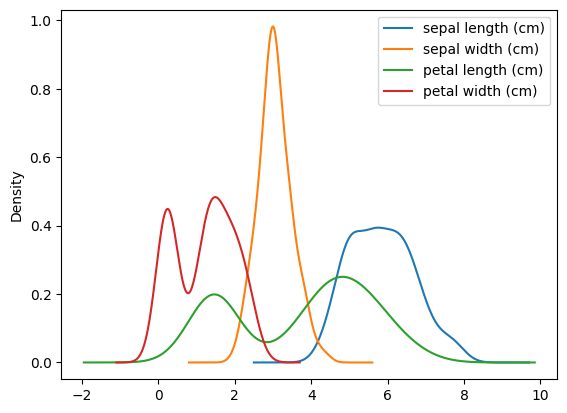

In [ ]:
iris_df.plot(kind='kde');

##### seaborn


##### t-SNE (t-Stochastic Neightbor Embedding)

**유용한 자료**
- [Why You Are Using t-SNE Wrong - towardsdatascience](https://towardsdatascience.com/why-you-are-using-t-sne-wrong-502412aab0c0)
- [How to Use t-SNE Effectively
](https://distill.pub/2016/misread-tsne/)

### 🔬 이상치 제거 (Remove Outlier)

> 이상치란 데이터셋 안에서 데이터들이 가지는 값의 분포에서 매우 동떨어진 값을 가지는 데이터를 말한다. 이상치가 섞여있으면 추후 학습에 영향을 주기 때문에 우리는 이 이상치가 데이타셋 속에 섞여있는지 확인해야하며 이를 제거할지 결정해야 한다.

1. 이상치 탐지 (Detect Outlier)
2. 이상치 제거 (Remove Outlier)


#### 1. 이상치 탐지 (Detect Outlier)

- IQR (Interquartile Range) 활용
- Isolation forest

**참고자료**
- [Novelty and Outlier Detection - sklearn 공식문서](https://scikit-learn.org/stable/modules/outlier_detection.html)


##### IQR (Interquartile Range) 활용

- $Q_1 - 1.5\ \mathbf{IQR}\ \sim\ Q_3 + 1.5\ \mathbf{IQR}$ 사이의 값을 벗어나는 모든 값을 이상치라고 가정하는 방법이다
- [pandas.DataFrame.boxplot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.boxplot.html) - 이상치를 시각적으로 쉽게 확인할 수 있다.
- [seaborn.boxplot](https://seaborn.pydata.org/generated/seaborn.boxplot.html) - 더욱 예쁜 그래프를 그릴 수 있다

`sepal width (cm)`에서 위 아래로 나타는 동그라미가 바로 이상치 값을 나타낸다

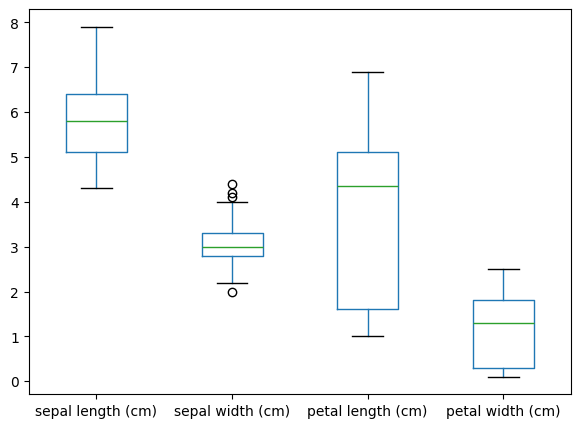

In [ ]:
# pandas는 바로 boxplot을 그릴 수 있는 기능을 지원한다
iris_df.boxplot(figsize=(7, 5), grid=False);

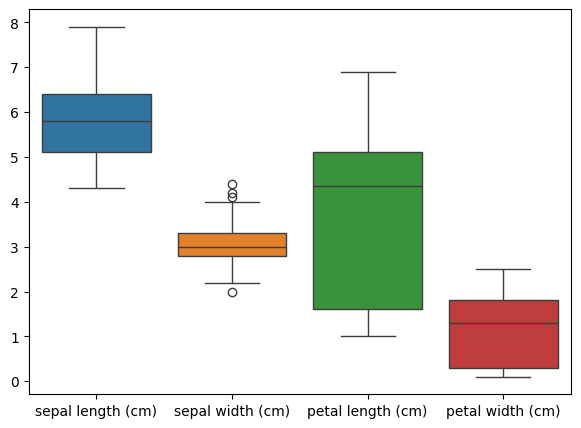

In [ ]:
# seaborn을 이용해 더욱 예쁘게 그래프를 그려보자
plt.figure(figsize=(7, 5))
sns.boxplot(data=iris_df);

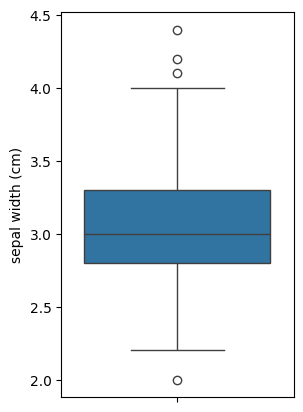

In [ ]:
# 이상치 값이 있는 단일 특징만을 볼 수도 있다
plt.figure(figsize=(3, 5))
sns.boxplot(y=iris_df['sepal width (cm)']);

##### Isolation forest
- [sklearn.ensemble.IsolationForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)

#### 2. 이상체 제거 (Remove Outlier)

> 이상치라고 해서 무조건 제거하면 안된다. 우리는 이 이상치가 단순한 오류인지 아닌지 분석 후에 만약 이상치가 오류가 아니라면 이를 제거할지 아니면 남겨둘지 프로젝트에 따라 기준을 세워 결정하여야 한다.

**이상치 발생 요인들**
1. 데이터셋 제작자의 실수
2. 관측 센서 오작동
3. 데이터의 진짜 특징


- IQR (Interquartile Range) 활용

##### IQR (Interquartile Range) 활용

In [ ]:
Q1 = iris_df['sepal width (cm)'].quantile(0.25)
Q3 = iris_df['sepal width (cm)'].quantile(0.75)

# IQR 계산하기
IQR = Q3 - Q1

# 이상치 경계선 계산
low_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

low_outlier = iris_df['sepal width (cm)'] <= low_bound
upper_outlier = iris_df['sepal width (cm)'] >= upper_bound

outlier = low_outlier | upper_outlier

# 이상치 표시
iris_df.loc[outlier]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
15,5.7,4.4,1.5,0.4,Iris-setosa
32,5.2,4.1,1.5,0.1,Iris-setosa
33,5.5,4.2,1.4,0.2,Iris-setosa
60,5.0,2.0,3.5,1.0,Iris-versicolor


### 🔬 결측치 채워넣기 (Fill Missing Value)

> 결측치란 말 그대로 데이터가 비어있는 것을 말한다. 데이터가 비어있으면 모델이 학습을 할 수 없기 때문에 우리는 이 결측치에 값을 대체하여 채우거나 아예 제거하여야 한다.

1. 결측치 탐지
2. 결측치 대체하기 (Imputation)
3. 결측치 삭제하기 (Deletion)

**결측치 종류**
- MCAR (Missing completely at random)
- MAR (Missing at random)
- MNAR (Missing not at random)

**유용한 자료**
- [Missing data - wikipedia](https://en.wikipedia.org/wiki/Missing_data)
- [Imputation of missing values - sklearn 공식문서](https://scikit-learn.org/stable/modules/impute.html)

In [ ]:
# 결측치가 있는 iris 데이터셋을 만들 것이기 때문에 copy()를 통해 새로운 df를 만든다
iris_na_df = iris_df.copy()

# 현재 iris 데이터셋에서는 결측치가 없기 때문에 의도적으로 몇개의 결측치를 만들자
na_indices = [1, 5, 30, 52, 102]
iris_na_df.loc[na_indices, 'sepal length (cm)'] = np.nan

#### 1. 결측치 탐지

> 결측치를 찾아내는데 유용한 라이브러리 및 기능들을 소개한다

- [pandas.isnull](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.isnull.html)
- [pandas.DataFrame.info](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html)
- [missingno](https://github.com/ResidentMario/missingno)

##### pandas.isnull

> 결측치를 탐지해서 bool값으로 결과를 돌려준다

탐지하는 null 종류
- None
- pd.NA
- np.nan

In [ ]:
pd.isnull(iris_df).sample(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
101,False,False,False,False,False
140,False,False,False,False,False
30,False,False,False,False,False


In [ ]:
# pandas.DataFrame에서 바로 적용할 수도 있다
iris_df.isnull().sample(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
55,False,False,False,False,False
105,False,False,False,False,False
114,False,False,False,False,False


##### pandas.DataFrame.info

- `Non-Null Count`를 통해 결측치가 존재하는지를 빠르게 파악할 수 있다
- `pd.options.display.max_info_rows`에 지정된 행의 수를 초과하면 `Non-Null Count`가 표시되지 않는다. 이때는 직접 이 값을 수정해주면 된다.

In [ ]:
# 여기에 표시되는 값보다 행의 수가 많아지면 info()는 Non-Null Count를 표시하지 않는다
pd.options.display.max_info_rows

1690785

In [ ]:
# sepal length 쪽에 5개의 결측치가 있음을 손쉽게 확인할 수 있다
iris_na_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  145 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   class              150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


##### missingno

> 한눈에 결측치를 쉽게 표시하는 시각화 라이브러리다

- matrix
- bar

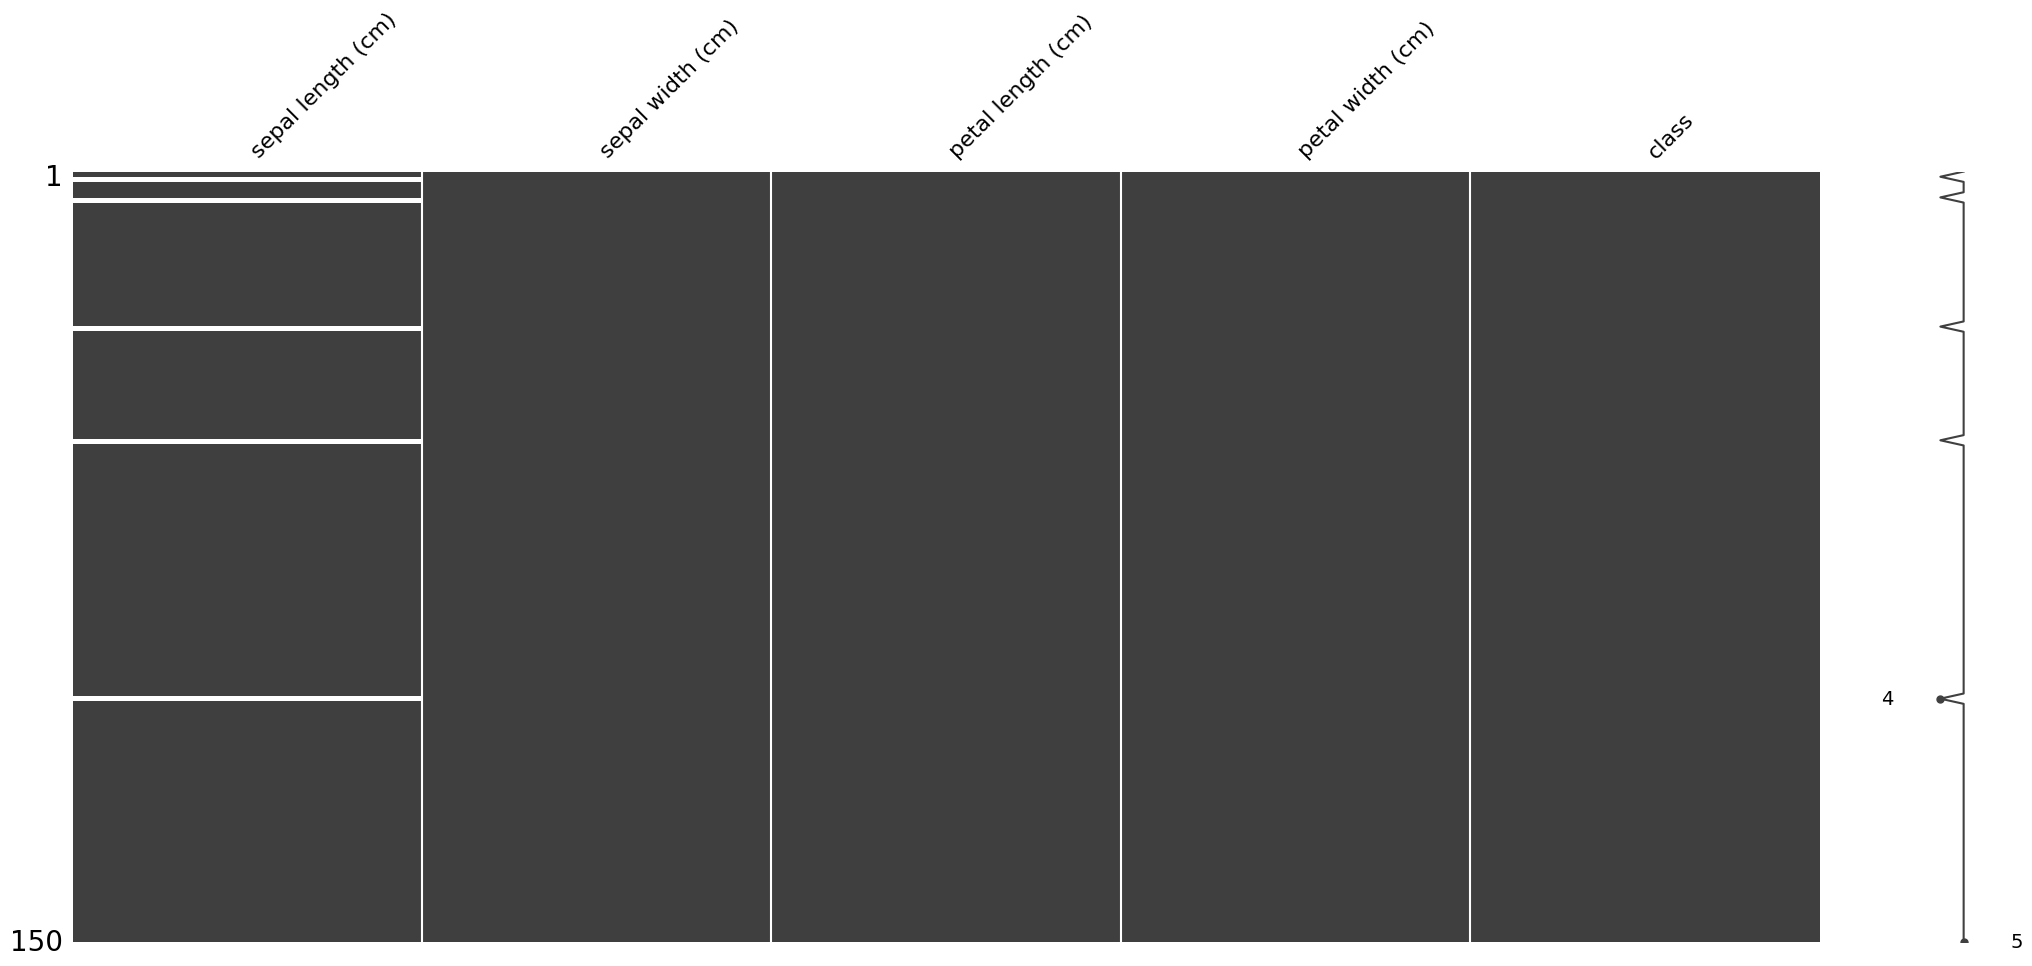

In [ ]:
# 결측치가 있는 부분은 흰색 선으로 표시된다
# 우측의 선 그래프는 데이터의 완성도를 표시하며 각 행의 최대 / 최소 결측치 갯수를 표시해준다
missingno.matrix(iris_na_df);

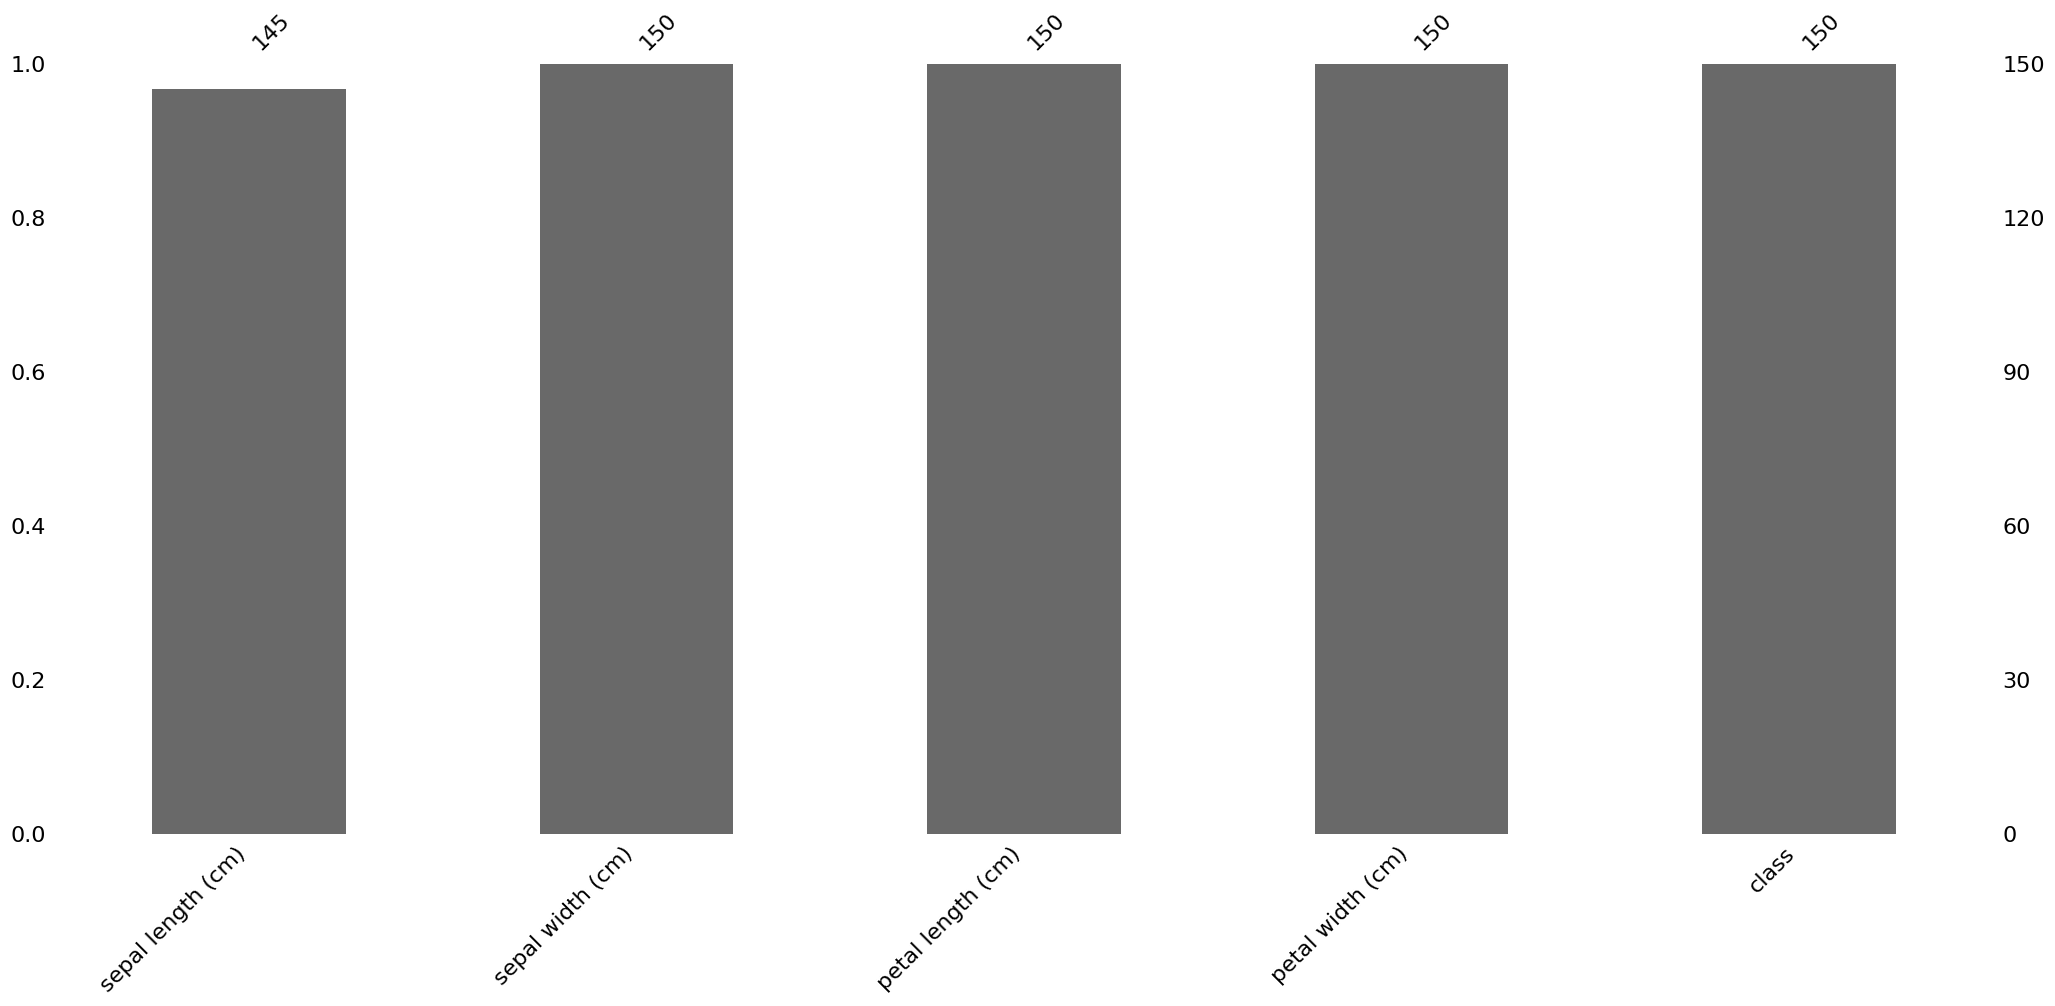

In [ ]:
missingno.bar(iris_na_df);

#### 2. 결측치 대체하기 (Imputation)

> 결측치에 대체할 값을 정하는 몇 가지 방법들을 소개한다. 우리는 결측치를 정확히 알 수 없으므로 추측을 통해서 대체 값을 찾아야 하며 이를 위해 통계값을 이용하거나 머신러닝 알고리즘을 활용할 수도 있다.

- 평균 / 중간값 / 최빈값
- 보간 (interpolate)
- 회귀 (regression)
- KNN

##### 평균 / 중간값 / 최빈값

> 직관적인 방법이며 자주 활용된다. 결측치가 존재하는 feature의 나머지 값들의 통계값으로 결측치를 대체하는 방법이다.

- [pandas.DataFrame.fillna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html)
- [sklearn.impute.SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer)
- **최빈값**의 경우 연속형 feature에서는 활용을 추천하지 않는다. 대부분의 값들이 고유하게 존재하므로 각 값들의 출현 빈도가 모두 1이 나올 확률이 높아 최빈값을 구하기가 힘들다

In [ ]:
# 평균 (mean) / 중간값 (median) / 최빈값(mode)
mean = iris_df['sepal length (cm)'].mean()
median = iris_df['sepal length (cm)'].median()
mode = iris_df['sepal length (cm)'].mode()

print(f'mean : {mean}, median : {median}, mode : {mode.values[0]}')

# 평균값으로 결측치 채우기
iris_na_df['sepal length (cm)'].fillna(mean)[na_indices]

mean : 5.843333333333334, median : 5.8, mode : 5.0


1      5.843333
5      5.843333
30     5.843333
52     5.843333
102    5.843333
Name: sepal length (cm), dtype: float64

In [ ]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

# SimpleImputer는 numpy를 이용하므로 df를 numpy로 변환한다
null_feature = iris_na_df['sepal length (cm)'].values.reshape(-1, 1)

imp_mean.fit(null_feature)
imp_mean.transform(null_feature)[na_indices]

array([[5.84413793],
       [5.84413793],
       [5.84413793],
       [5.84413793],
       [5.84413793]])

##### 보간 (interpolate)

> 결측치의 위, 아래 값을 고려하여 결측치에 들어갈 값을 정하는 방법이며 다양한 방법론이 존재한다

- [pandas.DataFrame.interpolate](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html)

In [ ]:
# reference - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html
s = pd.Series([0, 1, np.nan, 3])
s.interpolate()

0    0.0
1    1.0
2    2.0
3    3.0
dtype: float64

In [ ]:
s = pd.Series([np.nan, "single_one", np.nan,
               "fill_two_more", np.nan, np.nan, np.nan,
               4.71, np.nan])

# pad 방법을 사용하지만 2번까지만 채워넣는다
s.interpolate(method='pad', limit=2)

/var/folders/l1/t9xwrdv51cz9w5wqmx05zlr00000gn/T/ipykernel_28727/2359280229.py:6: FutureWarning: Series.interpolate with method=pad is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s.interpolate(method='pad', limit=2)


0              NaN
1       single_one
2       single_one
3    fill_two_more
4    fill_two_more
5    fill_two_more
6              NaN
7             4.71
8             4.71
dtype: object

In [ ]:
df = pd.DataFrame([(0.0, np.nan, -1.0, 1.0),
                   (np.nan, 2.0, np.nan, np.nan),
                   (2.0, 3.0, np.nan, 9.0),
                   (np.nan, 4.0, -4.0, 16.0)],
                  columns=list('abcd'))
df.interpolate(method='linear', limit_direction='forward', axis=0)

,a,b,c,d
0,0.0,NaN,-1.0,1.0
1,1.0,2.0,-2.0,5.0
2,2.0,3.0,-3.0,9.0
3,2.0,4.0,-4.0,16.0


##### 회귀 (regression)

> 만약 결측치가 존재하는 feature와 다른 feature들 사이에 상관관계가 존재한다면 우리는 회귀 알고리즘을 활용하여서 결측치 값을 예측해볼 수 있다

- [pandas.DataFrame.corr](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) - 상관관계 분석
- [sklearn.linear_model.LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html?highlight=linear%20regression#sklearn.linear_model.LinearRegression) - 연속형 feature 결측치 예측
- [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) - 범주형 feature 결측치 예측

In [ ]:
# 상관관계 분석
iris_na_df.corr()

ValueError: could not convert string to float: 'Iris-setosa'

결측치가 존재하는 feature가 `꽃받침 길이 (sepal length)`이며 다른 feature `꽃잎 길이 (petal length)`, `꽃잎 폭 (petal width)`와 **강한 상관관계(0.7 이상)**가 존재함을 알 수 있다.

이를 바탕으로 회귀를 할 수 있음을 알 수 있으며, `꽃받침 길이 (sepal length)`가 **연속형 feature**이므로 **선형 회귀 (linear regression)**을 사용할 수 있다.

- [상관관계와 선형회귀](https://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_correlation-regression/bs704_correlation-regression_print.html)

In [ ]:
# sepal length (cm)의 null / non null index
null = iris_na_df['sepal length (cm)'].isnull()
not_null = ~iris_na_df['sepal length (cm)'].isnull()

# not null
x_df = iris_na_df[['sepal width (cm)', 'petal length (cm)', 'petal width (cm)']][not_null]
y_df = iris_na_df[['sepal length (cm)']][not_null]

# null
x_null_df = iris_na_df[['sepal width (cm)', 'petal length (cm)', 'petal width (cm)']][null]

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(x_df, y_df)

# 결측치 예측
y_predict = model.predict(x_null_df)

결측치에 원래 들어있던 값과 비교하여 어느정도 차이가 있는지 확인해보자

In [ ]:
pd.DataFrame({'original': iris_df.iloc[na_indices]['sepal length (cm)'],
              'predict': y_predict.reshape(-1)})

,original,predict
1,4.9,4.689357
5,5.4,5.372545
30,4.8,4.894471
52,6.9,6.503659
102,7.1,6.814286


##### KNN
- [sklearn.neighbors.KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) - 연속형 feature 결측치 예측
- [sklearn.neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) - 범주형 feature 결측치 예측

In [ ]:
# sepal length (cm)의 null / non null index
null = iris_na_df['sepal length (cm)'].isnull()
not_null = ~iris_na_df['sepal length (cm)'].isnull()

# not null
x_df = iris_na_df[['sepal width (cm)', 'petal length (cm)', 'petal width (cm)']][not_null]
y_df = iris_na_df[['sepal length (cm)']][not_null]

# null
x_null_df = iris_na_df[['sepal width (cm)', 'petal length (cm)', 'petal width (cm)']][null]

In [ ]:
# sepal length (cm)은 연속형 feature이므로 KNN 회귀 사용
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor().fit(x_df, y_df)

# 결측치 예측
y_predict = model.predict(x_null_df)

결측치에 원래 들어있던 값과 비교하여 어느정도 차이가 있는지 확인해보자

In [ ]:
pd.DataFrame({'original': iris_df.iloc[na_indices]['sepal length (cm)'],
              'predict': y_predict.reshape(-1)})

,original,predict
1,4.9,4.60
5,5.4,5.22
30,4.8,4.82
52,6.9,6.56
102,7.1,7.06


#### 3. 결측치 삭제하기 (Deletion)

> 결측치를 채우지 않고 삭제하는 방법이다. 편의를 위해 데이터가 pandas DataFrame이라고 가정한다.

- 목록 삭제 (listwise)
- 단일값 삭제 (pairwise)

##### 목록 삭제 (listwise)

> DataFrame의 어떤 행에 하나의 결측치라도 존재하면 그 행을 삭제하는 방법이다

- [pandas.DataFrame.dropna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html)

```python
df.dropna()
```

In [ ]:
# 행 삭제 - 결측치 값이 존재하던 해당 행들이 전부 삭제된 것을 볼 수 있다
iris_na_df.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Index: 145 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  145 non-null    float64
 1   sepal width (cm)   145 non-null    float64
 2   petal length (cm)  145 non-null    float64
 3   petal width (cm)   145 non-null    float64
 4   class              145 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.8+ KB


##### 단일값 삭제 (pairwise)

> 우리가 분석에 사용하고자 하는 feature들에 한정하여 결측치가 존재하는 행을 삭제하는 방법이다. 어떤 feature들을 분석에 사용하느냐에 따라 삭제하는 행이 달라질 수 있다

- [pandas.DataFrame.dropna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html)

```python
df.dropna(subset=[FEATURES])
```

In [ ]:
# 결측치가 없는 feature들만을 선택할 경우 삭제되는 행이 없다
iris_na_df.dropna(subset=['sepal width (cm)', 'petal length (cm)', 'petal width (cm)']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  145 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   class              150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [ ]:
# 결측치가 존재하는 feature가 포함된 경우 결측치가 포함된 행은 모두 삭제된다
# sepal length (cm) - 결측치가 존재하는 feature
iris_na_df.dropna(subset=['sepal length (cm)', 'petal length (cm)', 'petal width (cm)']).info()

<class 'pandas.core.frame.DataFrame'>
Index: 145 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  145 non-null    float64
 1   sepal width (cm)   145 non-null    float64
 2   petal length (cm)  145 non-null    float64
 3   petal width (cm)   145 non-null    float64
 4   class              145 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.8+ KB


### 🔬 트랜스폼 (Transform)

> 데이터의 분포를 변화시키는 것을 트랜스폼이라고 한다. 스케일링이 분포 변화 없이 분포의 스케일만 변화시키는 것과 다르게 트랜스폼은 분포 자체를 변화시킨다. 트랜스폼은 모델이 데이터 사이의 패턴을 더욱 쉽게 파악할 수 있도록 도와준다.

- 트랜스폼 (Transform) - 분포 변화 ✔️
- 스케일링 (Scaling) - 분포 변화 ❌

1. 로그 (log)
2. 사분위수 (quantile)

**유용한 자료**
- [Effect of transforming the targets in regression model - sklearn 공식문서](https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html)

#### 로그 (log)

> 확률 분포를 로그 스케일로 변환하는 것으로 변환을 하고 싶은 feature에 로그를 취해주면 된다.

iris 데이터셋에는 skewed 분포의 feature가 없기 때문에, sklearn의 `make_regression`을 이용해 데이터셋을 생성한다.

- [sklearn.datasets.make_regression](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html#sklearn.datasets.make_regression)
- [numpy.expm1](https://numpy.org/doc/stable/reference/generated/numpy.expm1.html) - `exp(x) - 1`
- [scipy.stats.skew](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html)

**유용한 자료**
- [In linear regression, when is it appropriate to use the log of an independent variable instead of the actual values? - StackExchange](https://stats.stackexchange.com/questions/298/in-linear-regression-when-is-it-appropriate-to-use-the-log-of-an-independent-va)

In [ ]:
# reference - https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html
from sklearn.datasets import make_regression


# 데이터 생성
X, y = make_regression(n_samples=10000, noise=100, random_state=0)
y = np.expm1((y + abs(y.min())) / 200)
y_trans = np.log1p(y)

In [ ]:
# 왜도 (skew) 측정
from scipy.stats import skew

print(f"skewed 분포의 skew : {skew(y)}, 정규분포의 skew : {skew(y_trans)}")

skewed 분포의 skew : 9.500802276118158, 정규분포의 skew : 0.0053749979998693985


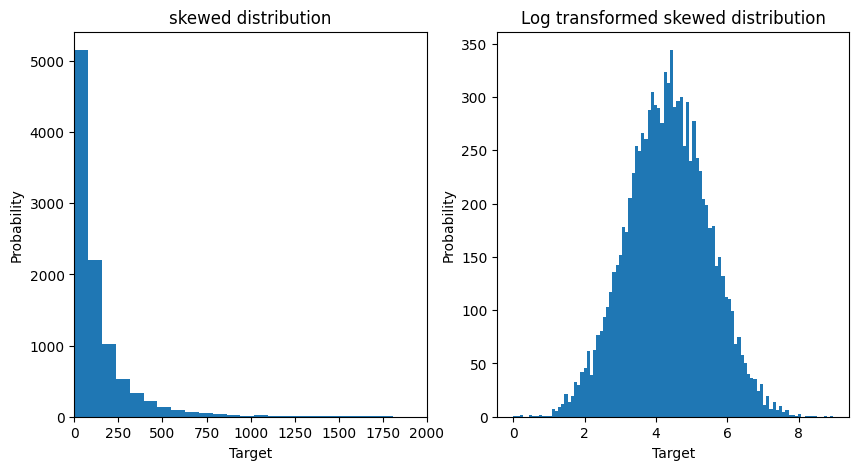

In [ ]:
# 그래프 그리기
fig = plt.figure(figsize=(10, 5))

fig.add_subplot(1, 2, 1)
plt.hist(y, bins=100)
plt.xlim([0, 2000])
plt.ylabel('Probability')
plt.xlabel('Target')
plt.title('skewed distribution')

fig.add_subplot(1, 2, 2)
plt.hist(y_trans, bins=100)
plt.ylabel('Probability')
plt.xlabel('Target')
plt.title('Log transformed skewed distribution');

#### 사분위수 (quantile)

> 주어진 확률분포를 다른 확률분포로 변환하는 것이 quantile 트랜스폼이다.

- 균일 (uniform)
- 정규 (normal)

⛔ **quantile transform** 사용 주의 사항
- [Warning - sklearn 공식문서](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.quantile_transform.html)
- Train / Test 셋으로 데이터를 나누기 전에 적용하면 Data leak가 일어난다. 그렇기 때문에 변환은 데이터를 나눈 이후에 적용해야 한다.

**유용한 자료**
- [How to Use Quantile Transforms for Machine Learning - Machine Learning Mastery](https://machinelearningmastery.com/quantile-transforms-for-machine-learning/)

##### 균일 (uniform)

> 확률 분포를 0과 1사이의 값을 가지는 균일 분포로 변환한다

- [sklearn.preprocessing.QuantileTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html#sklearn.preprocessing.QuantileTransformer)

```python
QuantileTransformer(output_distribution='uniform')
```

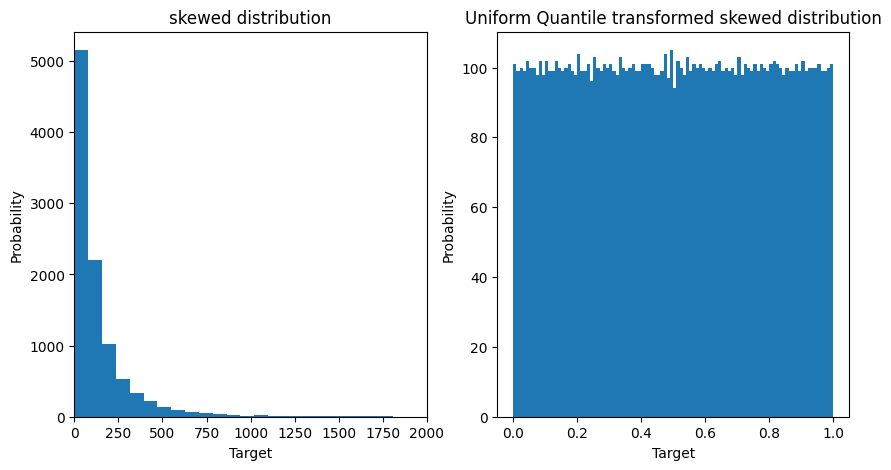

In [ ]:
from sklearn.preprocessing import QuantileTransformer

# log에서 제작한 데이터셋을 그대로 사용한다
# 변환은 uniform으로 진행한다
y_trans = QuantileTransformer(output_distribution='uniform').fit_transform(y.reshape(-1, 1))


# 그래프 그리기
fig = plt.figure(figsize=(10, 5))

fig.add_subplot(1, 2, 1)
plt.hist(y, bins=100)
plt.xlim([0, 2000])
plt.ylabel('Probability')
plt.xlabel('Target')
plt.title('skewed distribution')

fig.add_subplot(1, 2, 2)
plt.hist(y_trans, bins=100)
plt.ylabel('Probability')
plt.xlabel('Target')
plt.title('Uniform Quantile transformed skewed distribution');

##### 정규 (normal)

> 확률 분포를 정규 분포로 변환한다

- [sklearn.preprocessing.QuantileTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html#sklearn.preprocessing.QuantileTransformer)

```python
QuantileTransformer(output_distribution='normal')
```

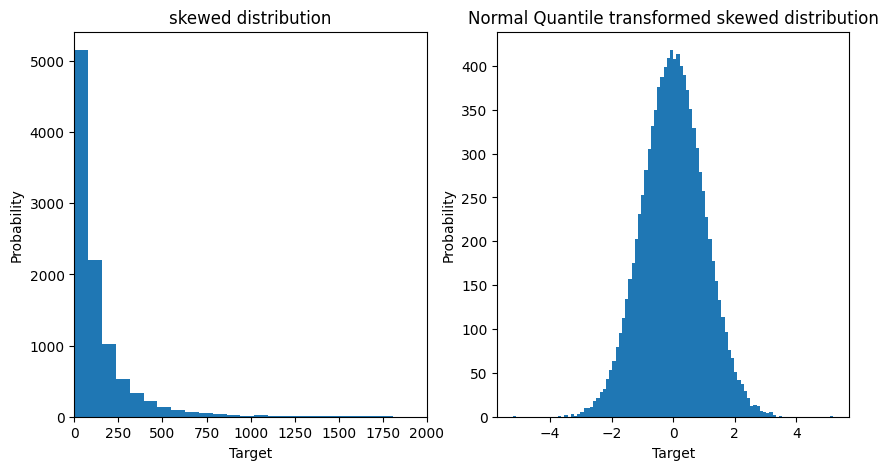

In [ ]:
from sklearn.preprocessing import QuantileTransformer

# log에서 제작한 데이터셋을 그대로 사용한다
# 변환은 normal으로 진행한다
y_trans = QuantileTransformer(output_distribution='normal').fit_transform(y.reshape(-1, 1))


# 그래프 그리기
fig = plt.figure(figsize=(10, 5))

fig.add_subplot(1, 2, 1)
plt.hist(y, bins=100)
plt.xlim([0, 2000])
plt.ylabel('Probability')
plt.xlabel('Target')
plt.title('skewed distribution')

fig.add_subplot(1, 2, 2)
plt.hist(y_trans, bins=100)
plt.ylabel('Probability')
plt.xlabel('Target')
plt.title('Normal Quantile transformed skewed distribution');


### 🔬 스케일링 (Scaling)

> 데이터 분포의 범위를 조절해준다. 회귀나 딥러닝에서 스케일링은 매우 중요한 비중을 차지하며 feature간 값의 범위가 매우 상이할 때 스케일링이 이뤄지지 않는 경우 학습이 불안정해질 수 있다.

1. sklearn 라이브러리 사용하기

**유용한 자료**
- [Feature scaling - wikipedia](https://en.wikipedia.org/wiki/Feature_scaling)
- [Feature Scaling - Why it is required? - Medium](https://medium.com/@rahul77349/feature-scaling-why-it-is-required-8a93df1af310)
- [Feature scaling (normalization) in multiple regression analysis with normal equation method? - stackoverflow](https://stackoverflow.com/questions/34148912/feature-scaling-normalization-in-multiple-regression-analysis-with-normal-equa)
- [조건수 (condition number) - wikipedia](https://ko.wikipedia.org/wiki/%EC%A1%B0%EA%B1%B4%EC%88%98)
- [Compare the effect of different scalers on data with outliers - sklearn 공식문서](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)

#### 1. sklearn 라이브러리 사용하기

> sklearn은 다양한 종류의 스케일링 기능들을 제공한다.

- [sklearn.preprocessing.MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler)
- [sklearn.preprocessing.MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html#sklearn.preprocessing.MaxAbsScaler)
- [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
- [sklearn.preprocessing.RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler)
- [sklearn.preprocessing.Normalizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html#sklearn.preprocessing.Normalizer)

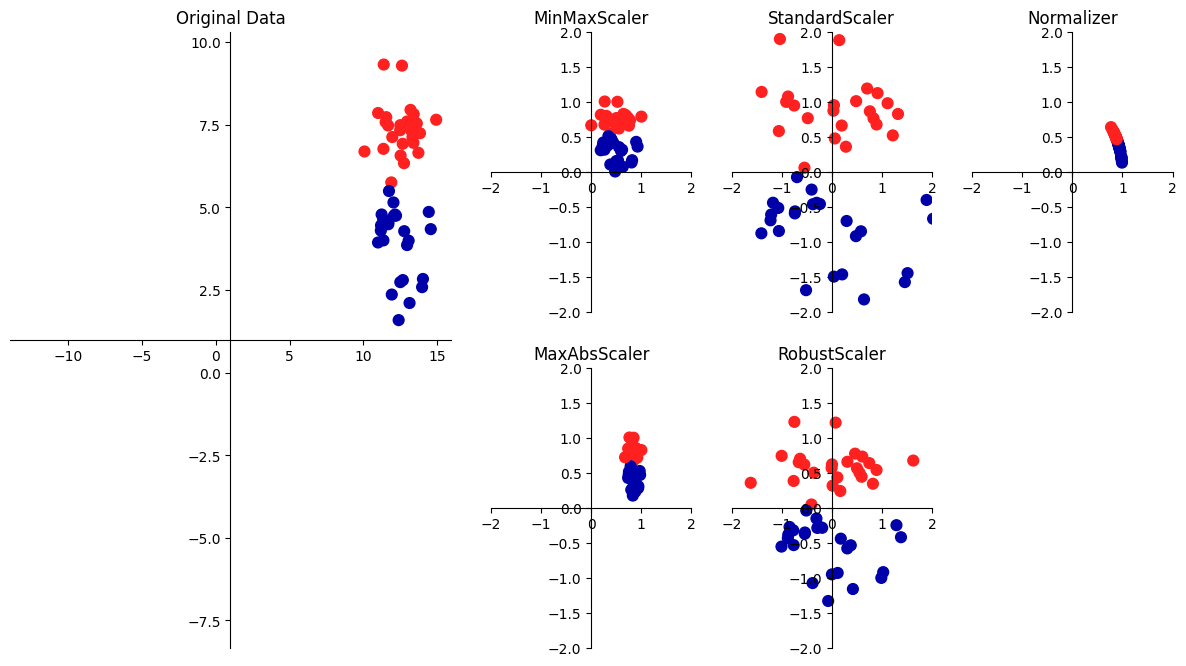

In [ ]:
#@title ##### **스케일링(Scaling) 시각화 비교**
# reference - https://github.com/amueller/mglearn/blob/106cf48ef03710ef1402813997746741aa6467da/mglearn/plot_scaling.py#L9

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_blobs
from sklearn.preprocessing import (StandardScaler, MinMaxScaler, Normalizer,
                                   RobustScaler, MaxAbsScaler)

cm2 = ListedColormap(['#0000aa', '#ff2020'])

def plot_scaling():
    X, y = make_blobs(n_samples=50, centers=2, random_state=4, cluster_std=1)
    X += 3

    plt.figure(figsize=(15, 8))
    main_ax = plt.subplot2grid((2, 5), (0, 0), rowspan=3, colspan=2)

    main_ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm2, s=60)
    maxx = np.abs(X[:, 0]).max()
    maxy = np.abs(X[:, 1]).max()

    main_ax.set_xlim(-maxx + 1, maxx + 1)
    main_ax.set_ylim(-maxy + 1, maxy + 1)
    main_ax.set_title("Original Data")
    other_axes = [plt.subplot2grid((2, 5), (i, j))
                  for j in range(2, 5) for i in range(2)]

    # 마지막 axes 비우기
    other_axes[-1].axis('off')

    for ax, scaler in zip(other_axes, [MinMaxScaler(),
                                       MaxAbsScaler(),
                                       StandardScaler(),
                                       RobustScaler(),
                                       Normalizer(norm='l2')]):
        X_ = scaler.fit_transform(X)
        ax.scatter(X_[:, 0], X_[:, 1], c=y, cmap=cm2, s=60)
        ax.set_xlim(-2, 2)
        ax.set_ylim(-2, 2)
        ax.set_title(type(scaler).__name__)

    other_axes.append(main_ax)

    for ax in other_axes:
        ax.spines['left'].set_position('center')
        ax.spines['right'].set_color('none')
        ax.spines['bottom'].set_position('center')
        ax.spines['top'].set_color('none')
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')

plot_scaling()

##### Min Max Scalar

> feature의 값이 0과 1 사이에 위치하도록 스케일링

In [ ]:
# reference - https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

X = [[4, -1, 2, 2],
     [1, 3, 9, -3],
     [5, 7, -5, 1],
     [20, 5, 2, 1],
     [1, 1, 1, 100]]

scaler = MinMaxScaler().fit(X)
scaler.transform(X)

array([[0.15789474, 0.        , 0.5       , 0.04854369],
       [0.        , 0.5       , 1.        , 0.        ],
       [0.21052632, 1.        , 0.        , 0.03883495],
       [1.        , 0.75      , 0.5       , 0.03883495],
       [0.        , 0.25      , 0.42857143, 1.        ]])

##### Max Abs Scalar

> feature의 최대값이 1이 되도록 스케일링

In [ ]:
from sklearn.preprocessing import MaxAbsScaler

X = [[4, -1, 2, 2],
     [1, 3, 9, -3],
     [5, 7, -5, 1],
     [20, 5, 2, 1],
     [1, 1, 1, 100]]

scaler = MaxAbsScaler().fit(X)
scaler.transform(X)

array([[ 0.2       , -0.14285714,  0.22222222,  0.02      ],
       [ 0.05      ,  0.42857143,  1.        , -0.03      ],
       [ 0.25      ,  1.        , -0.55555556,  0.01      ],
       [ 1.        ,  0.71428571,  0.22222222,  0.01      ],
       [ 0.05      ,  0.14285714,  0.11111111,  1.        ]])

##### Standard Scalar

> feature를 정규화한다.

$\Large z = \frac{(x\ -\ \mu)}{\sigma}$
- $\mu$ : 평균 (mean)
- $\sigma$ : 표준편차 (standard deviation)

In [ ]:
from sklearn.preprocessing import StandardScaler

X = [[4, -1, 2, 2],
     [1, 3, 9, -3],
     [5, 7, -5, 1],
     [20, 5, 2, 1],
     [1, 1, 1, 100]]

scaler = StandardScaler().fit(X)
scaler.transform(X)

array([[-0.31063037, -1.41421356,  0.04499213, -0.45571832],
       [-0.73421724,  0.        ,  1.61971657, -0.58091566],
       [-0.16943475,  1.41421356, -1.52973232, -0.48075779],
       [ 1.94849961,  0.70710678,  0.04499213, -0.48075779],
       [-0.73421724, -0.70710678, -0.17996851,  1.99814957]])

##### Robust Scalar

> Standard Scalar과 비슷한 방식으로 동작히며 중간값(median)과 IQR(Interquartile Range)을 사용하여 스케일링하기 때문에 이상치(outlier)에 영향을 덜 받는다(robust).

- `Standard Scalar` : 평균(mean)과 표준편차(standard deviation)을 사용
- `Robust Scalar` : 중간값(median)과 IQR(Interquartile Range)를 사용

In [ ]:
from sklearn.preprocessing import RobustScaler

X = [[4, -1, 2, 2],
     [1, 3, 9, -3],
     [5, 7, -5, 1],
     [20, 5, 2, 1],
     [1, 1, 1, 100]]

scaler = RobustScaler().fit(X)
scaler.transform(X)

array([[ 0.  , -1.  ,  0.  ,  1.  ],
       [-0.75,  0.  ,  7.  , -4.  ],
       [ 0.25,  1.  , -7.  ,  0.  ],
       [ 4.  ,  0.5 ,  0.  ,  0.  ],
       [-0.75, -0.5 , -1.  , 99.  ]])

##### Normalizer

> 위의 스케일링 기법들과 다르게 각각의 **feature에 개별로 적용되는 것이 아니라** 모든 **특징 벡터(feature vector)들에게 개별적으로 적용**된다. pandas DataFrame 기준으로 설명하면 열에 적용되던 스케일링 기법이 행에 적용되는 셈이다. **특징 벡터(feature vector)**의 norm이 모두 1이 되도록 스케일링하며 **특징 벡터(feature vector)**의 길이는 신경쓰지 않고 방향 혹은 각도가 중요할 때 사용된다.

In [ ]:
from sklearn.preprocessing import Normalizer

X = [[4, -1, 2, 2],
     [1, 3, 9, -3],
     [5, 7, -5, 1],
     [20, 5, 2, 1],
     [1, 1, 1, 100]]

scaler = Normalizer().fit(X)
scaler.transform(X)

array([[ 0.8       , -0.2       ,  0.4       ,  0.4       ],
       [ 0.1       ,  0.3       ,  0.9       , -0.3       ],
       [ 0.5       ,  0.7       , -0.5       ,  0.1       ],
       [ 0.96448564,  0.24112141,  0.09644856,  0.04822428],
       [ 0.0099985 ,  0.0099985 ,  0.0099985 ,  0.99985003]])

## 🧪 인코딩 (Encoding)
- 순서 인코딩 (Ordinal Encoding)
- 라벨 인코딩 (Label Encoding)
- 원핫 인코딩 (One Hot Encoding)
- 타겟 인코딩 (Target Encoding)

**인코딩(Encoding)은 feature가 범주형(Category)일 때 적용하며 범주형을 수치형으로 변환하는 것을 말한다**
> 우리는 **데이터셋 이해하기**에서 각 feature가 범주형인지 수치형인지 알아보았다. iris 데이터셋의 경우는 모든 feature가 연속형이었지만, 대부분의 데이터셋은 범주형 feature를 포함하고 있다.

- 인코딩(Encoding)은 중요한 요소는 아니다. 인코딩(Encoding)에서는 성능 차이가 많이 나지는 않는다. 만약 사용하는 모델이 트리(Tree) 모델이면 더욱 상관없으며 순서 인코딩(Ordinal Encoding)만 해도 충분하다. 다만 인코딩 하는 feature의 cardinality가 커질경우 인코딩에 따라 트리(Tree)모델에서의 성능 차이가 많이 벌어지므로 신중히 선택하여야 한다.

⭐ **인코딩 종류의 다양성** ⭐
> 실전에서 가장 자주 사용되는 인코딩(Encoding) 방법들을 소개하였지만 실제 인코딩 방법은 더 다양하다. 관심이 있다면 **유용한 자료**의 첫 번째 글 혹은 `category_encoders` 라이브러리의 공식 문서를 참조하자
- [Category Encoders 공식문서](https://contrib.scikit-learn.org/category_encoders/#)

**유용한 자료**
- [All about Categorical Variable Encoding - towardsdatascience](https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02)
- [Why decision tree needs categorical variable to be encoded? - StackExchange](https://datascience.stackexchange.com/questions/52066/why-decision-tree-needs-categorical-variable-to-be-encoded)
- [One-Hot Encoding is making your Tree-Based Ensembles worse, here’s why? - towardsdatascience](https://towardsdatascience.com/one-hot-encoding-is-making-your-tree-based-ensembles-worse-heres-why-d64b282b5769)
- [Visiting: Categorical Features and Encoding in Decision Trees - Medium](https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931)

In [ ]:
# 실습을 위한 범주형 데이터
duck_df = pd.DataFrame({'type': ['goose', 'duck', 'goose', 'duck', 'duck', 'duck'],
                        'color': ['red', 'green', 'blue', 'green', 'green', 'red'],
                        'smartness': ['A', 'C', 'B', 'C', 'A', 'A']})
duck_df

,type,color,smartness
0,goose,red,A
1,duck,green,C
2,goose,blue,B
3,duck,green,C
4,duck,green,A
5,duck,red,A



### ⚗️ 순서 인코딩 (Ordinal Encoding)

> 인코딩하는 feature의 카테고리들을 나타나는 순서대로 0부터 시작하는 숫자 정수로 인코딩한다. 각 카테고리에 인코딩할 숫자는 직접 지정할 수 있다. 순서를 가진 숫자로 인코딩되는 만큼 각 카테고리 간에 연관되므로 순서형(Oridinal)일 경우 사용해야 한다.

- 다수의 feature들을 한번에 인코딩 할 수 있다.
- 트리(Tree) 모델의 경우에는 명목형(Nominal)인 경우에도 사용할 수 있다.

1. 카테고리의 순서를 지정하지 않을 경우
2. 카테고리의 순서를 지정할 경우

- [sklearn.preprocessing.OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)
    

#### 1. 카테고리의 순서를 지정하지 않을 경우
```python
OrdinalEncoder()
```

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

X = duck_df.smartness.values.reshape(-1, 1)
print(X)

enc = OrdinalEncoder()
enc.fit(X)
enc.transform(X)

[['A']
 ['C']
 ['B']
 ['C']
 ['A']
 ['A']]


array([[0.],
       [2.],
       [1.],
       [2.],
       [0.],
       [0.]])

In [ ]:
# 카테고리 확인
enc.categories_

[array(['A', 'B', 'C'], dtype=object)]

#### 2. 카테고리의 순서를 지정할 경우
```python
OrdinalEncoder(categories=[['C', 'B', 'A']])
```

In [ ]:
print(X)

enc = OrdinalEncoder(categories=[['C', 'B', 'A']])
enc.fit(X)
enc.transform(X)

[['A']
 ['C']
 ['B']
 ['C']
 ['A']
 ['A']]


array([[2.],
       [0.],
       [1.],
       [0.],
       [2.],
       [2.]])

In [ ]:
# 카테고리 확인
enc.categories_

[array(['C', 'B', 'A'], dtype=object)]


### ⚗️ 라벨 인코딩 (Label Encoding)

> 순서 인코딩 (Ordinal Encoding)과 방식은 동일하지만 한개의 feature에만 적용 가능하며 target(Y)에 적용할 목적을 가지고 있다.

- `순서 인코딩 (Ordinal Encoding)`
    - input(X)에 적용
    - 다수의 feature들을 동시에 인코딩
    - 순서 지정 가능
- `라벨 인코딩 (Label Encoding)`
    - target(Y)에 적용
    - 한개의 feature만 인코딩
    - 순서 지정 불가능

⛔ input(X)의 feature 각각을 순서 지정 없이 인코딩 할 경우 라벨 인코딩(Label Encoding)을 사용해도 무방하나 sklearn은 target(Y)이 아닌 input(X)에 적용하는 것을 권장하지 않는다.

- [sklearn.preprocessing.LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder)

In [ ]:
from sklearn.preprocessing import LabelEncoder

X = duck_df.type
print(X)

enc = LabelEncoder()
enc.fit(X)
enc.transform(X)

0    goose
1     duck
2    goose
3     duck
4     duck
5     duck
Name: type, dtype: object


array([1, 0, 1, 0, 0, 0])

### ⚗️ 원핫 인코딩 (One Hot Encoding)

> feature의 카테고리를 0과 1로 이루어진 벡터로 인코딩한다. 이 벡터의 길이는 카테고리 수이다.

- [sklearn.preprocessing.OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

X = duck_df.smartness.values.reshape(-1, 1)
print(X)

enc = OneHotEncoder()
enc.fit(X)
enc.transform(X).toarray()

[['A']
 ['C']
 ['B']
 ['C']
 ['A']
 ['A']]


array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]])

### ⚗️ 타겟 인코딩 (Target Encoding)

> **평균 인코딩 (Mean Encoding)**이라고도 불린다. feature의 카테고리를 해당 카테고리의 target값의 평균으로 인코딩하는 방법이다.

1. 타겟 인코딩 (Target Encoding) 사용
2. Smoothing

- [category_encoders.target_encoder.TargetEncoder](https://contrib.scikit-learn.org/category_encoders/targetencoder.html)

**유용한 자료**
- [Mean (likelihood) encodings: a comprehensive study - Kaggle](https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study)

#### 1. 타겟 인코딩 (Target Encoding) 사용

> `category_encoders` 라이브러리를 이용하여 타겟 인코딩을 해보자. `type`을 target으로 가정한다.

⛔ 주의사항 ⛔
- Train 셋에 Overfitting될 수 있다
- Train 셋과 Test 셋의 label값 분포가 상이하면 문제가 된다

In [ ]:
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import LabelEncoder

# Target Encoding은 target의 값이 숫자여야 하므로 라벨 인코딩을 한다
X = duck_df[['color', 'smartness']]
y = LabelEncoder().fit_transform(duck_df[['type']].values.ravel())

duck_df['target'] = y
duck_df

,type,color,smartness,target
0,goose,red,A,1
1,duck,green,C,0
2,goose,blue,B,1
3,duck,green,C,0
4,duck,green,A,0
5,duck,red,A,0


In [ ]:
enc = TargetEncoder()
enc.fit(X, y)
enc.transform(X)

,color,smartness
0,0.356975,0.333333
1,0.281845,0.286050
2,0.420072,0.420072
3,0.281845,0.286050
4,0.281845,0.333333
5,0.356975,0.333333


#### 2. Smoothing

>  타겟 인코딩의 overfitting을 완화시키고자 각 카테고리의 target 평균값을 전체 target 평균값으로 이동시키는 방법이다.

- 인터넷 상에 알려진 smoothing
- **category_encoders** 라이브러리 smoothing


##### 인터넷 상에 알려진 smoothing

$\large \mathbb{smoothing}_c = \frac{(mean_c\ \times\ n_c\ +\ global\_mean\ \times\ \alpha)}{n_c\ +\ \alpha}$
- $mean_c$ : 카테고리 c에 속하는 target의 평균값
- $n_c$ : 카테고리 c의 행 수
- $global\_mean$ : 전체 target의 평균값
- $\alpha$ : hyperparameter로 default는 1이며 값이 커질수록 전체 target 평균에 가까워진다

**참고자료**
- [Target encoding done the right way - Blog](https://maxhalford.github.io/blog/target-encoding/)

In [ ]:
def smoothing_internet(mean_c, n_c, global_mean, alpha):
    return (mean_c*n_c + global_mean*alpha)/(n_c + alpha)

In [ ]:
# global mean
global_mean = duck_df.target.mean()

# smartness의 mean_c와 n_c
agg = duck_df.groupby('smartness')['target'].agg(['count', 'mean'])
n_c = agg['count']
mean_c = agg['mean']

print(n_c, mean_c)
print(global_mean)

smartness
A    3
B    1
C    2
Name: count, dtype: int64 smartness
A    0.333333
B    1.000000
C    0.000000
Name: mean, dtype: float64
0.3333333333333333


In [ ]:
print(smoothing_internet(mean_c, n_c, global_mean, 1))

smartness
A    0.333333
B    0.666667
C    0.111111
dtype: float64


##### **category_encoders** 라이브러리 smoothing
> 알려진 smooth하고 다르게 `category_encoders`에서 사용하는 smooth 방법은 다르다.

**참고자료**
- [target_encoder.py - Github](https://github.com/scikit-learn-contrib/category_encoders/blob/master/category_encoders/target_encoder.py)

In [ ]:
def smoothing(mean_c, n_c, global_mean, alpha):
    # default
    min_samples_leaf = 1

    smoove = 1 / (1 + np.exp(-(n_c - min_samples_leaf) / alpha))
    smoothing = global_mean * (1 - smoove) + mean_c * smoove
    smoothing[n_c == 1] = global_mean

    return smoothing

In [ ]:
print(smoothing(mean_c, n_c, global_mean, 1))

smartness
A    0.333333
B    0.333333
C    0.089647
dtype: float64


###**콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.

